In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.autograd import Variable
from torch.autograd import Variable
import torchvision.models as models

import numpy as np
import matplotlib.pyplot as plt
import math
from graphviz import Digraph
import re

% matplotlib inline

CUDA = False

In [2]:
class CausalConv1d(nn.Conv1d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True):
        super(CausalConv1d, self).__init__(in_channels, out_channels, kernel_size, stride=stride, padding=0,
            dilation=dilation, groups=groups, bias=bias)

        self.left_padding = dilation * (kernel_size - 1)
        
    def forward(self, input):
        temp = torch.unsqueeze(input, 0)
        x = F.pad(temp, (self.left_padding, 0, 0, 0))
        x = torch.squeeze(x, 0)
        
        return super(CausalConv1d, self).forward(x)

In [3]:
class OneHot(nn.Module):
    def __init__(self, quant):
        super(OneHot, self).__init__()
        self.one = torch.sparse.torch.eye(quant)
        
    def forward(self, input):
        return Variable(self.one.index_select(0, input.data)).unsqueeze(0).transpose(1,2)

In [6]:
data = Variable(torch.LongTensor(np.random.randint(1,5,10)))

onehot = OneHot(5)
onehot(data), data

(Variable containing:
 (0 ,.,.) = 
    0   0   0   0   0   0   0   0   0   0
    0   0   1   1   0   1   0   0   0   0
    0   0   0   0   1   0   0   0   1   0
    0   1   0   0   0   0   0   1   0   1
    1   0   0   0   0   0   1   0   0   0
 [torch.FloatTensor of size 1x5x10], Variable containing:
  4
  3
  1
  1
  2
  1
  4
  3
  2
  3
 [torch.LongTensor of size 10])

In [4]:
class WaveNet(nn.Module):
    def __init__(self, quant = 256, res_size = 512, skip_size = 256, dilation_layers = 10, stacks = 3):
        super(WaveNet, self).__init__()
        self.dilation_layers = dilation_layers
        self.dilations = dilations = [(2**dilation) for dilation in range(dilation_layers)] * stacks
        self.one_hot = OneHot(quant)
        
        self.causal_conv = CausalConv1d(quant, res_size, 1)
        
        self.dial_tanh_conv = nn.ModuleList([CausalConv1d(skip_size, skip_size, 2, dilation = d) for d in dilations])
        self.dial_sigm_conv = nn.ModuleList([CausalConv1d(skip_size, skip_size, 2, dilation = d) for d in dilations])
        
        self.dial_skip_conv = nn.ModuleList([CausalConv1d(skip_size, skip_size, 1) for _ in dilations])
        self.dial_res_conv = nn.ModuleList([CausalConv1d(skip_size, res_size, 1) for _ in dilations])
        
        self.end_conv1 = nn.Conv1d(in_channels = skip_size, out_channels = skip_size, kernel_size = 1)
        self.end_conv2 = nn.Conv1d(in_channels = skip_size, out_channels = quant, kernel_size = 1)

    def forward(self, input):
        output = self.one_hot(input)
        output = self.causal_conv(output)
        
        skip_sum = []
        for s, t, skip_conv, res_conv in zip(self.dial_sigm_conv, self.dial_tanh_conv, self.dial_skip_conv, self.dial_res_conv):
            res_output = output
            
            gate_output = self.gated_unit(res_output, s, t)
            
            output = res_conv(gate_output)
            output = output + res_output[:,:,-output.size(2):]
            
            skip = skip_conv(gate_output)
            skip_sum.append(skip)
        
        output = sum([s[:,:,-output.size(2):] for s in skip_sum])
        
        output = self.postprocess(output)
        
        return output
    
    def gated_unit(self, input, dial_sigm_conv, dial_tanh_conv):
        input_sigmoid = input[0][256:].unsqueeze(0)
        input_tanh = input[0][:256].unsqueeze(0)
        
        output_sigmoid = dial_sigm_conv(input_sigmoid)
        output_tanh = dial_tanh_conv(input_tanh)
        
        output = nn.functional.sigmoid(output_sigmoid) * nn.functional.tanh(output_tanh)
        
        return output
        
    def postprocess(self, input):
        output = nn.functional.elu(input)
        output = self.end_conv1(output)
        output = nn.functional.elu(output)
        output = self.end_conv2(output).squeeze(0).transpose(0,1)

        return output

# Test Network

In [8]:
net = WaveNet()
batch = Variable(torch.from_numpy(np.random.randint(0,256,10000).astype(np.long)))
net(batch)

In [5]:
def mu_encoder(input):        
    mu = torch.FloatTensor([255])
    x_mu = torch.sign(input) * torch.log1p(mu * torch.abs(input)) / torch.log1p(mu)
    x_mu = ((x_mu + 1) / 2 * mu + 0.5).long()
    
    return x_mu.type(torch.FloatTensor) 

In [6]:
def mu_decoder(input):
    mu = torch.FloatTensor([255])
    x = ((input) / mu) * 2 - 1.
    x = torch.sign(x) * (torch.exp(torch.abs(x) * torch.log1p(mu)) - 1.) / mu
    
    return x

# Data Generator

In [7]:
def batch_generator():
    while True:
        xs = np.linspace(0, np.pi*10, 4000)
        ys = np.sin(xs) #+ np.random.rand(4000)*0.2-0.1
        ys = ys.astype(np.float32) # default is np.float64
        x = torch.from_numpy(ys).view(1,1,-1)
#         x = torch.from_numpy(ys[:3999]).view(1,1,-1)
#         y = torch.from_numpy(ys[1:4000]).view(1,1,-1)
        if (torch.cuda.is_available() and CUDA):
            x = x.cuda()
            y = y.cuda()
            
        yield x #, y #Variable(x), Variable(y)

g = batch_generator()

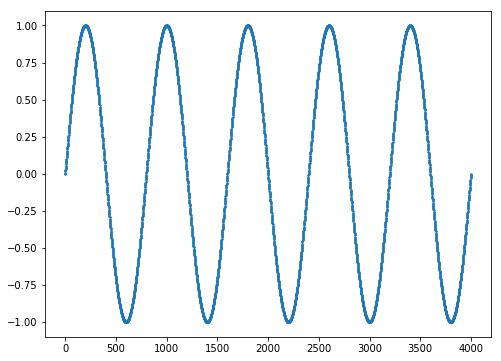

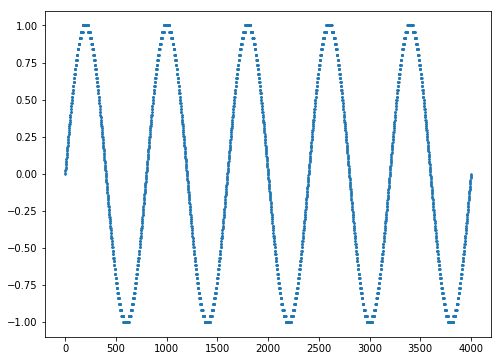

In [8]:
x = next(g)
plt.figure(figsize=[8,6])
plt.plot(Variable(x).cpu().data.numpy()[0][0],'.', ms=3)

temp = mu_encoder(x)
# plt.figure(figsize=[8,6])
# plt.plot(Variable(temp).cpu().data.numpy()[0][0],'.', ms=3)

temp = mu_decoder(temp)
plt.figure(figsize=[8,6])
plt.plot(Variable(temp).cpu().data.numpy()[0][0],'.', ms=3)

In [ ]:
net = WaveNet()

optimizer = optim.Adam(net.parameters(),lr=0.01)

batch_size = 64
loss_save = []
max_epoch = 2

for epoch in range(max_epoch):
    optimizer.zero_grad()
    loss = 0
    for _ in range(batch_size):
        batch = next(g)
        batch = Variable(mu_encoder(batch).type(torch.LongTensor))
        x = batch[0][0][:-1]
        logits = net(x)
        sz = logits.size(0)
        loss = loss + nn.functional.cross_entropy(logits, batch[0][0][-sz:])
    loss = loss/batch_size
    loss.backward()
    optimizer.step()
    loss_save.append(loss.data[0])
    
    # monitor progress
    if epoch%1 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.data[0]))
        batch = next(g)
        logits = net(batch[:-1])
        _, i = logits.max(dim=1)
        plt.figure(figsize=[16,4])
        plt.plot(i.data.tolist())
        plt.plot(batch.data.tolist()[sum(net.dilations)+1:],'.',ms=1)
        plt.title('epoch {}'.format(epoch))
        plt.tight_layout()
        plt.show()